In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter

In [3]:
from fastai.vision import *

In [4]:
path=Path('/media/sasha/My Passport/kaggle/deepfake_detection_challenge')

In [5]:
train_path = path/'train'
assert Path(train_path).exists()

In [6]:
train_videos = get_files(train_path, recurse=True, followlinks=True, extensions=['.mp4'])
train_videos = [str(f) for f in train_videos]
len(train_videos)
train_videos = train_videos

In [7]:
json_files = get_files(train_path, recurse=True, followlinks=True, extensions=['.json'])
json_files

[PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_18/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_0/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_1/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_10/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_11/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_12/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_13/metadata.json'),
 PosixPath('/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfd

In [9]:
video_map = {}
fake_orig_map = {}
for json_file in json_files:
    with open(json_file) as json_str:
        json_data = json.load(json_str)
        for kv in json_data.items():
            file_path = json_file.parents[0]/kv[0]
            if not file_path.exists():
                print(f'{file_path} does not exist')
            else:
                label = kv[1]['label']
                video_map[str(file_path)] = label
                if label == 'FAKE' and 'original' in kv[1]:
                    fake_orig_map[file_path.stem] = Path(kv[1]['original']).stem

/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_18/wipjitfmta.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_18/wpuxmawbkj.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_18/pvohowzowy.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_35/innmztffzd.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_35/cfxiikrhep.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_35/dzjjtfwiqc.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_35/zzfhqvpsyp.mp4 does not exist
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_35/glleqxulnn.mp4 does not exist


In [10]:
fake_orig_map

{'iueofqnitn': 'xatruuhtpv',
 'vcbgvdnvlc': 'duplyxsudb',
 'btsyjxkhsz': 'sxwdupqijr',
 'vznxsshhdy': 'uhrvmearuj',
 'qjqafllxfz': 'zcbhzngluj',
 'mwapcvbqco': 'oihnqftsls',
 'cqahjlxssx': 'qgiygiqybs',
 'wcovfnrnev': 'fdgbgxddbt',
 'yazrsbwbnd': 'rswmrfllpo',
 'cedydlkhff': 'upezcrcdqz',
 'cqidzzgjjr': 'fwzjvfcdji',
 'kxspftcepn': 'vhkxxdxgcn',
 'hzoajqujew': 'lkmgyyyrpk',
 'pzntdswwjs': 'zovvcyafzh',
 'senrirjhwh': 'vngmafoyik',
 'zetkmzprvm': 'afqhjqevie',
 'bgneigofxm': 'zxuopquqrt',
 'nzxncyfeaj': 'msqdpgokcx',
 'ggysrtzwya': 'bpwynspgkx',
 'uoxlvtlelj': 'tjqrbghiiz',
 'asyvhuglhs': 'bpwynspgkx',
 'ttorxjzuwe': 'lwziasznji',
 'hxewjezhlo': 'fwzjvfcdji',
 'aydiylfrlh': 'lkmgyyyrpk',
 'efqhfcoyla': 'rswmrfllpo',
 'yaahpquxyp': 'rwanhvnnhs',
 'ofnpozaxzx': 'lwziasznji',
 'qxudrmbfes': 'oihnqftsls',
 'dhbwrtvcwd': 'tgvymitbia',
 'cgsqfmhssz': 'xlwmfyphoo',
 'nluleubpho': 'lwziasznji',
 'jehmjvcccg': 'msqdpgokcx',
 'ejcqfsdlmu': 'bxkugtuzbx',
 'qpxqyrfwec': 'sxwdupqijr',
 'ceeodwphfb':

In [11]:
video_stats = Counter([kv[1] for kv in video_map.items()])
video_stats

Counter({'FAKE': 99992, 'REAL': 19154})

In [12]:
video_total = len(video_map)
video_stats['FAKE'] / video_total, video_stats['REAL'] / video_total

(0.839239252681584, 0.16076074731841605)

## Create MTCNN and Inception Resnet models

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [14]:
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()
torch_home

'/root/.cache/torch'

In [15]:
# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
# Load face detector
# mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False, device='cuda:0', image_size=225)

In [16]:
# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

## Process train videos

In [17]:
X = []

In [18]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = PIL.Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

### Save Images

In [19]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=120, resize=0.25, n_frames=5)

torch.Size([3, 225, 225])


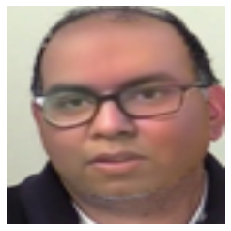

In [20]:
extracted_video = detection_pipeline(train_videos[0])
face = extracted_video[0]
print(face.shape)
plt.imshow(face.squeeze().permute(1, 2, 0).int().numpy())
plt.axis('off');

In [21]:
Image(face.squeeze() / 255.).save('xxx.jpg')

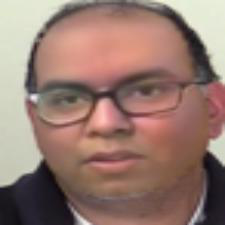

In [22]:
PIL.Image.open('xxx.jpg')

In [23]:
!rm 'xxx.jpg'

### Extract the images

In [24]:
faces_path = train_path/'faces'

In [25]:
if not os.path.exists(faces_path):
    os.mkdir(faces_path)

In [ ]:
start = time.time()
n_processed = 0
Y = []
with torch.no_grad():
    for i, filename in tqdm(enumerate(train_videos), total=len(train_videos)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            # Filter out frames without faces
            faces = [f for f in faces if f is not None]
            if len(faces) > 0:
                train_video_name = Path(filename).stem
                video_faces_path = faces_path/train_video_name
                if not os.path.exists(video_faces_path):
                    os.mkdir(video_faces_path)
                for i, face in enumerate(faces):
                    Image(face.squeeze() / 255.).save(video_faces_path/f'{i}.jpg')
            else:
                print(f'No faces for {filename}')

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print('Exception:', e)
            X.append(None)
            Y.append(None)
            
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_18/hkwdkixksd.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/akeixdinzr.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/awxoipyrhc.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/bplholcbjb.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/ccsogyuwic.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/chnlzyfsrd.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/cmnoqaneou.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/ctxlrubjof.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_tra

No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/yivfufgxsi.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/yjtykxbnao.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/ypyibrpbpv.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/zpwikgggfn.mp4
No faces for /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/dfdc_train_part_33/zugcxgrmcn.mp4


In [31]:
!ls /media/sasha/My\ Passport/kaggle/deepfake_detection_challenge/train/faces/opbjreysjj

0.jpg  1.jpg  2.jpg  3.jpg  4.jpg


### Load some images

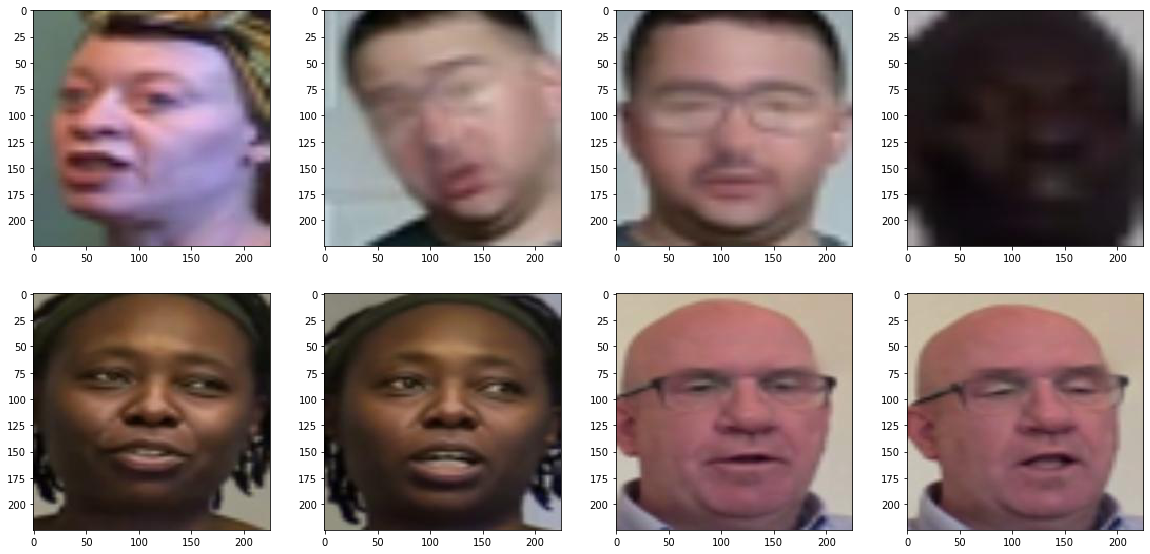

In [149]:
import matplotlib.image as mpimg

def display_images(sample_images):
    fig=plt.figure(figsize=(20, 20))
    rows = 4
    cols = 4
    for i, img_path in enumerate(sample_images):
        fig.add_subplot(rows, cols, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        
sample_images = [faces_path/'opbjreysjj/0.jpg', faces_path/'nemmjvieky/0.jpg', faces_path/'nemmjvieky/1.jpg', 
                     faces_path/'lwepwikzfr/2.jpg', faces_path/'opfwbdvone/0.jpg', faces_path/'opfwbdvone/1.jpg',
                    faces_path/'fclarssgkh/0.jpg', faces_path/'fclarssgkh/1.jpg']
display_images(sample_images)

In [131]:
def generate_file_ds(ds_name='simple_dataset.csv', photo_num=0):
    with open(train_path/ds_name, 'w') as csv:
        for e in video_map.items():
            stem = Path(e[0]).stem
            image_path = Path(faces_path/stem)
            if image_path.exists():
                fake_path = ''
                if stem in fake_orig_map and Path(faces_path/fake_orig_map[stem]).exists():
                    if Path(Path(faces_path/fake_orig_map[stem])/f'{photo_num}.jpg').exists():
                        fake_path = Path(Path(faces_path/fake_orig_map[stem])/f'{photo_num}.jpg')
                actual_image = Path(image_path/f'{photo_num}.jpg')
                if actual_image.exists():
                    csv.write(f'{actual_image},{e[1]},{fake_path}\n')

In [132]:
generate_file_ds()

In [133]:
!head '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/simple_dataset.csv'

/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/iueofqnitn/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/xatruuhtpv/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/vcbgvdnvlc/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/duplyxsudb/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/btsyjxkhsz/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/sxwdupqijr/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/vznxsshhdy/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/uhrvmearuj/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/qjqafllxfz/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/zcbhzngluj/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/mw

In [134]:
!tail '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/simple_dataset.csv'

/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/igaobtaeuk/0.jpg,REAL,
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/kstoczbyzr/0.jpg,FAKE,
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/iojhndegmj/0.jpg,REAL,
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/bneuvofkbh/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gwkxazzmmr/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/ehsxbdyiog/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gwkxazzmmr/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/buhshnytys/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/iojhndegmj/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/bbltbwkpzh/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/t

In [173]:
counter = Counter()
real_fake_map = {}
with open(train_path/'simple_dataset.csv', 'r') as f:
    with open(train_path/'real_fake_dataset.csv', 'w') as csv:
        lines = f.readlines()
        for l in lines:
            splits = l.split(',')
            is_fake = splits[1] == 'FAKE'
            if is_fake and splits[2].strip() != '' or is_fake == False:
                counter.update(splits[1][0])
                csv.write(f'{splits[0]},{splits[1]},{splits[2]}')
            if is_fake and splits[2].strip() != '':
                real_fake_map[splits[2]] = splits[0]
print(counter, len(real_fake_map))

Counter({'F': 59728, 'R': 11435}) 11391


In [174]:
!head '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/real_fake_dataset.csv'

/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/iueofqnitn/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/xatruuhtpv/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/vcbgvdnvlc/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/duplyxsudb/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/btsyjxkhsz/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/sxwdupqijr/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/vznxsshhdy/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/uhrvmearuj/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/qjqafllxfz/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/zcbhzngluj/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/mw

In [175]:
!tail '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/real_fake_dataset.csv'

/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/cpkyabfzlc/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gfikyugpkq/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/lewemordqy/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/fgpfxeovsh/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/igaobtaeuk/0.jpg,REAL,
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/iojhndegmj/0.jpg,REAL,
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/bneuvofkbh/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gwkxazzmmr/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/ehsxbdyiog/0.jpg,FAKE,/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gwkxazzmmr/0.jpg
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/f

In [176]:
!wc -l '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/real_fake_dataset.csv'

71163 /media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/real_fake_dataset.csv


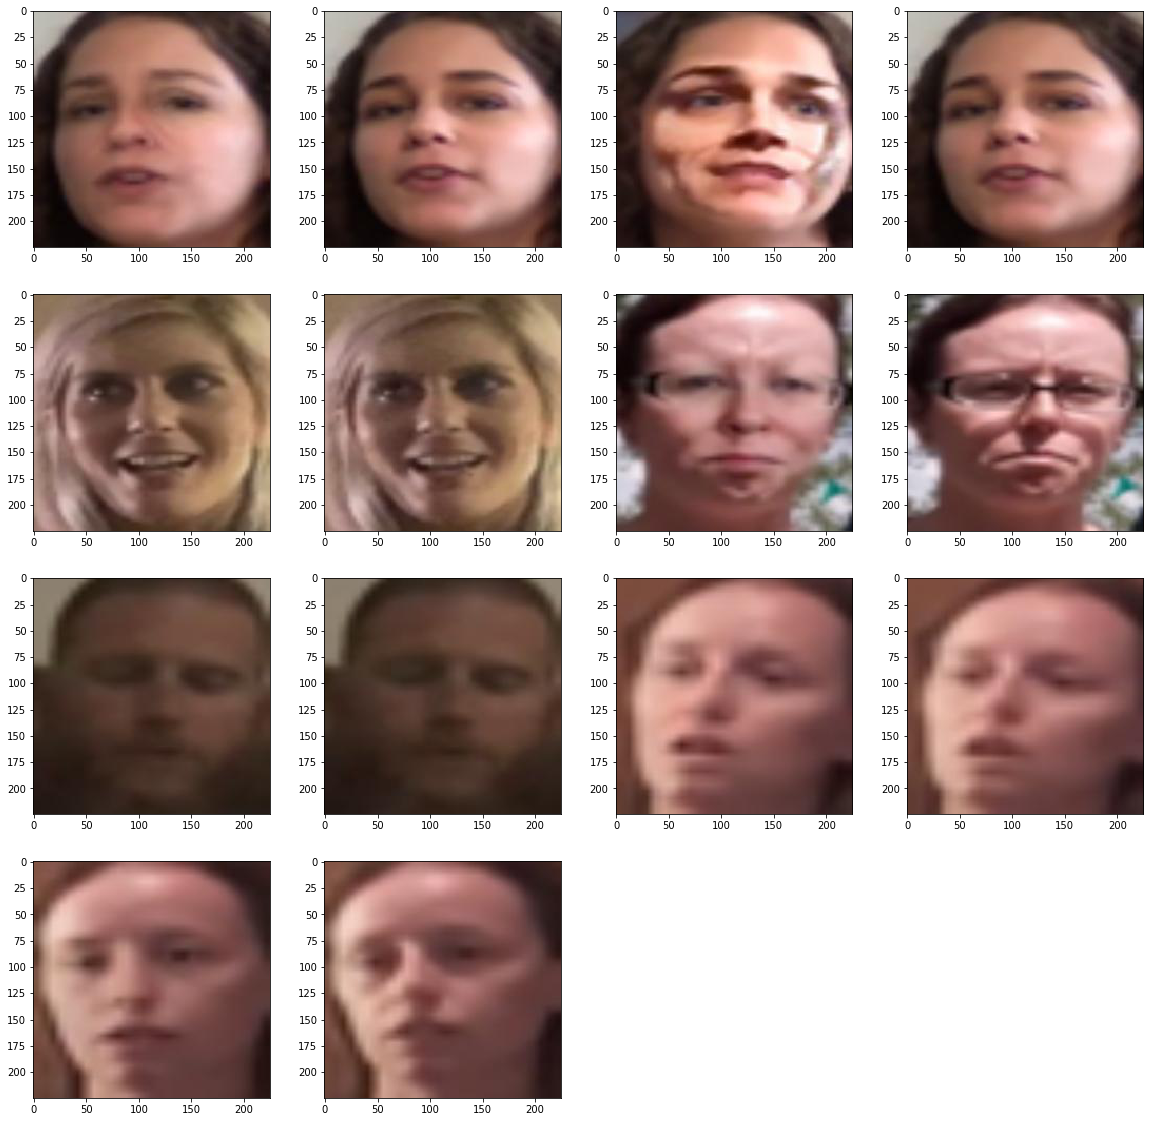

In [177]:
display_images(['/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/cpkyabfzlc/0.jpg', 
                '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gfikyugpkq/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/lewemordqy/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/gfikyugpkq/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/ktfxoeictt/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/igaobtaeuk/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/cedydlkhff/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/upezcrcdqz/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/wcovfnrnev/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/fdgbgxddbt/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/vcbgvdnvlc/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/duplyxsudb/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/btsyjxkhsz/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/sxwdupqijr/0.jpg'])

In [192]:
with open(train_path/'balanced_dataset.csv', 'w') as f:
    f.write(f'path,class\n')
    for e in real_fake_map.items():
        f.write(f'{e[0].strip()},REAL\n')
        f.write(f'{e[1].strip()},FAKE\n')

In [193]:
!head -100 '{train_path/'balanced_dataset.csv'}'

path,class
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/xatruuhtpv/0.jpg,REAL
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/hcxeunezjk/0.jpg,FAKE
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/duplyxsudb/0.jpg,REAL
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/bgcolixxne/0.jpg,FAKE
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/sxwdupqijr/0.jpg,REAL
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/hfkarniexj/0.jpg,FAKE
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/uhrvmearuj/0.jpg,REAL
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/ynwazhtsul/0.jpg,FAKE
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/zcbhzngluj/0.jpg,REAL
/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/pzahbznjkk/0.jpg,FAKE
/media/sasha/My Passport/kaggle/deepfak

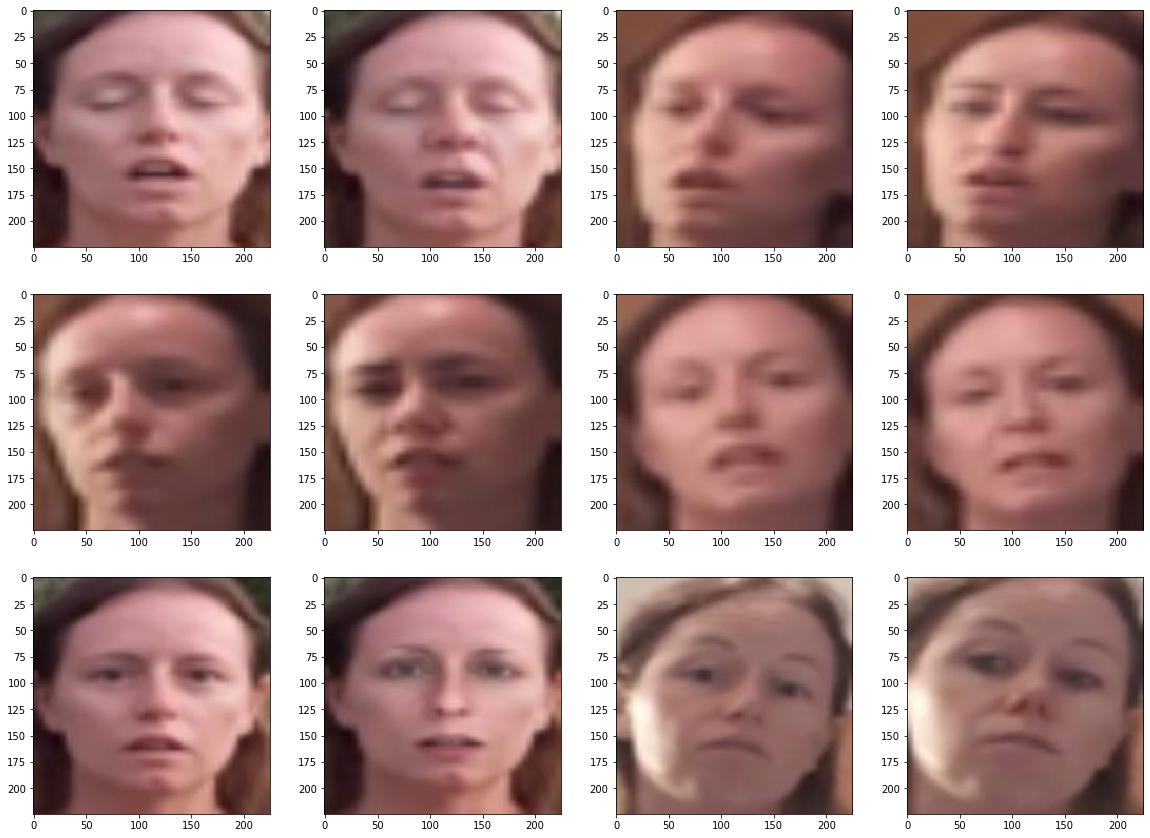

In [189]:
display_images(['/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/xatruuhtpv/0.jpg', 
                '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/hcxeunezjk/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/duplyxsudb/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/bgcolixxne/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/sxwdupqijr/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/hfkarniexj/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/uhrvmearuj/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/ynwazhtsul/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/ewbpzlfdgk/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/szgiedcosa/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/hazsnizlii/0.jpg',
               '/media/sasha/My Passport/kaggle/deepfake_detection_challenge/train/faces/yfpklcjcmu/0.jpg'])